# Louis George    

## Modeling

In [29]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier

import joblib

import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='lougeo', api_key=os.environ.get("PLOTLY_API"))

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading in the data

In [30]:
X_train_tfidf = pd.read_csv('../../data/X_train_tfidf.csv')
X_test_tfidf = pd.read_csv('../../data/X_test_tfidf.csv')

In [31]:
X_train_countv = pd.read_csv('../../data/X_train_countv.csv')
X_test_countv = pd.read_csv('../../data/X_test_countv.csv')

In [32]:
y_imdb_train = pd.read_csv('../../data/y_imdb_train.csv')
y_rt_train = pd.read_csv('../../data/y_rt_train.csv')
y_profit_train = pd.read_csv('../../data/y_profit_train.csv')

y_imdb_test = pd.read_csv('../../data/y_imdb_test.csv')
y_rt_test = pd.read_csv('../../data/y_rt_test.csv')
y_profit_test = pd.read_csv('../../data/y_profit_test.csv')

### Exploring the possibility of using Latent Dirichlet Allocation for decomposition      

Due to the differences in scale between the genre dummies, part of speech counts, and word vectors, I will use only the word vectors. Scaling is not required when modeling using the full data set with Logistic Regression and Decision Tree based models, so this won't be an issue going forward.

In [77]:
X_train_countv_vecs = X_train_countv.iloc[:, 28:]
X_test_countv_vecs = X_test_countv.iloc[:, 28:]

In [ ]:
topic_num = [3, 5, 10, 20]

train_scores = []
test_scores = []

for i in topic_num:
    lda = LatentDirichletAllocation(n_components=i).fit(X_train_countv_vecs)
    lda_train_weights = lda.transform(X_train_countv_vecs)
    lda_test_weights = lda.transform(X_test_countv_vecs)
    
    logreg = LogisticRegression().fit(lda_train_weights, y_imdb_train)
    train_scores.append(logreg.score(lda_train_weights, y_imdb_train))
    test_scores.append(logreg.score(lda_test_weights, y_imdb_test))

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(topic_num, train_scores, marker='.', label='train')
plt.plot(topic_num, test_scores, marker='.', label='test')
plt.legend()

As we can see from this graph, LDA decomposition is not going to give us any good results. For fun, let's see what the topics look like for one of the more reasonable results:

In [6]:
# Function which shows the features with the highest coefficients for each topic
def print_top_words(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        twords = ''.join([feature_names[i] + ' <br>' for i in topic.argsort()[:-n_top_words - 1:-1]])
        topic = {topic_idx:twords}
        topics.update(topic)
    return topics

In [21]:
topic_num = 20

# Fitting the LDA
lda = LatentDirichletAllocation(n_components=topic_num).fit(X_train_countv_vecs)

#transforming for t-SNE
lda_transformed = lda.transform(X_train_countv_vecs)

In [22]:
# Getting top tokens for each topic
n_top_words = 20
feature_names = X_train_countv_vecs.columns

topics = print_top_words(lda, feature_names, n_top_words)

This is a lot to look at, and even if there were fewer topics it would still be difficult for me to just look at these lists of words and make any sense out of it (These are just 20 words out of the whole data set!). To simplify this task let's make some plots! Below are a 2d, and 3d tSNE plots classed using KMeans clustering:

#### 2D t-SNE plot

In [21]:
my_tSNE = TSNE(n_components=2)
X_tSNE = my_tSNE.fit_transform(lda_transformed)

k_means_model = KMeans(n_clusters = 20)
k_means_model.fit(X_tSNE)
pred_labels = k_means_model.labels_

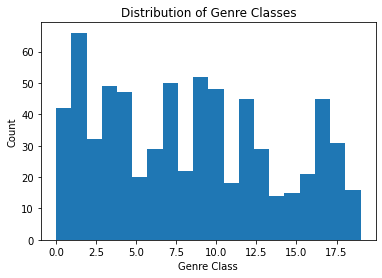

In [22]:
plt.figure()
plt.hist(pred_labels, bins=20)
plt.title("Distribution of Genre Classes")
plt.xlabel("Genre Class")
plt.ylabel("Count")
plt.show();

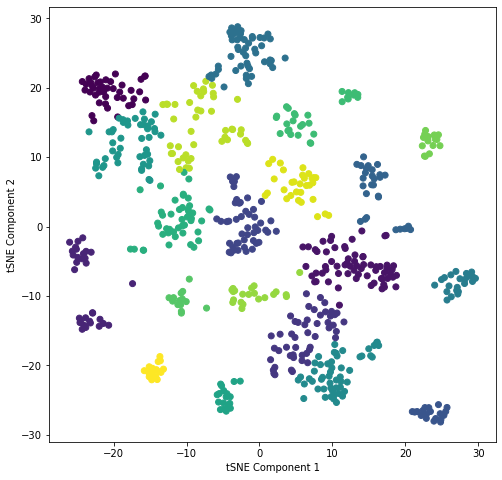

In [23]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1], c=pred_labels)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

Looks like there is some distinct clustering going on! Let's see what this looks like in 3D!

#### 3D t-SNE

In [23]:
scaled_X_train = StandardScaler().fit_transform(lda_transformed)

my_tSNE_3d = TSNE(n_components=3)
X_tSNE_3d = my_tSNE_3d.fit_transform(scaled_X_train)

k_means_model_3d = KMeans(n_clusters = 20)
k_means_model_3d.fit(X_tSNE_3d)
pred_labels_3d = k_means_model_3d.labels_

In [24]:
ref = [topics[i] for i in pred_labels_3d]

In [25]:
ref2 = pd.DataFrame([pred_labels_3d, X_tSNE_3d[:, 2], X_tSNE_3d[:, 1], X_tSNE_3d[:, 0], ref]).T

In [78]:
fig = go.Figure()

for i in range(20):
    data = ref2[ref2[0] == i]
    fig.add_trace(go.Scatter3d(
                                    x=data[1],
                                    y=data[2],
                                    z=data[3],
                                    mode='markers', 
                                    meta=data, 
                                    hovertemplate='%{meta[4]}' + 
                                                  '<extra></extra>', 
                                    showlegend=False 
                                    ))

camera = dict(eye=dict(x=1, y=2, z=0.2))

fig.update_layout(scene_camera=camera)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30), 
                  height=600, 
                  width=600, 
                  title_text="t-SNE Visualization of LDA Groupings")
fig.show()

# Loading onto cloud
#py.iplot(fig, filename="tSNE")

### Logistic Regression Models

Formatting the targets for ingestion

In [33]:
targets = [['IMDb', y_imdb_train, y_imdb_test], 
           ['Rotten Tomatoes', y_rt_train, y_rt_test], 
           ['Profit Margin', y_profit_train, y_profit_test]]

In [27]:
def log_modeler(targets):
    
    scores = []
    reports = []
    
    for source, y_train, y_test in targets:
        # Pipeline
        estimators = [('model', LogisticRegression())]

        pipe = Pipeline(estimators)

        # Grid search
        param_grid = [{'model':[LogisticRegression()],
                       'model__penalty':['l1', 'l2'],
                       'model__C':np.logspace(-2, 2, 5, 10)}]

        grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_tfidf, y_train)
        
        # Pickling the model for reference when graphing
        joblib.dump(grid, f'../models/{source.split()[0]}_logreg_ref.pkl')
        
        # Saving the scores
        scores.append([grid.score(X_train_tfidf, y_train), grid.score(X_test_tfidf, y_test)])
        
        # Calculating prediction metrics
        y_test_pred = grid.predict(X_test_tfidf)
        
        reports.append(classification_report(y_test, y_test_pred, output_dict=True))
        
    return scores, reports

Calling the model function, and saving the scores, and precision reports as csvs

In [28]:
logreg_scores, logreg_reports = log_modeler(targets)

In [77]:
df_logreg_scores = pd.DataFrame(logreg_scores, columns=['train', 'test'], 
                                index=['IMDb', 'RT', 'Profit'])
df_logreg_scores.to_csv('../../data/logreg_scores.csv')

In [76]:
template = pd.DataFrame({'target':['IMDb', 'IMDb', 'RT', 'RT', 'Profit', 'Profit'], 
                         'class':[0,1,0,1,0,1]})
df_logreg_results = pd.DataFrame([logreg_reports[0]['0'], logreg_reports[0]['1'], 
                                  logreg_reports[1]['0'], logreg_reports[1]['1'], 
                                  logreg_reports[2]['0'], logreg_reports[2]['1']], index=range(6))
df_logreg = pd.concat([template, df_logreg_results], axis=1)
df_logreg.to_csv('../../data/logreg_results.csv', index=False)

In [85]:
print(df_logreg_scores.to_markdown())
print(df_logreg.to_markdown())

|        |    train |     test |
|:-------|---------:|---------:|
| IMDb   | 0.671491 | 0.632035 |
| RT     | 0.68741  | 0.558442 |
| Profit | 0.59479  | 0.627706 |
|    | target   |   class |   precision |   recall |   f1-score |   support |
|---:|:---------|--------:|------------:|---------:|-----------:|----------:|
|  0 | IMDb     |       0 |    0.576923 | 0.463918 |   0.514286 |        97 |
|  1 | IMDb     |       1 |    0.660131 | 0.753731 |   0.703833 |       134 |
|  2 | RT       |       0 |    0.603896 | 0.69403  |   0.645833 |       134 |
|  3 | RT       |       1 |    0.467532 | 0.371134 |   0.413793 |        97 |
|  4 | Profit   |       0 |    0.347826 | 0.101266 |   0.156863 |        79 |
|  5 | Profit   |       1 |    0.658654 | 0.901316 |   0.761111 |       152 |


### Random Forest Model

In [56]:
def rf_modeler(targets):
    
    scores = []
    reports = []
    
    for source, y_train, y_test in targets:
        
        # Pipeline
        estimators = [('model', RandomForestClassifier())]
        pipe = Pipeline(estimators)
        
        # Grid search
        param_grid = [{'model':[RandomForestClassifier()],
                       'model__max_depth':[5, None],
                       'model__n_estimators':[50, 100, 200, 500]}]

        grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_tfidf, y_train)

        # Pickling the model
        joblib.dump(grid, f'../models/{source.split()[0]}_rf_ref.pkl')
        
        # Saving the scores
        scores.append([grid.score(X_train_tfidf, y_train), grid.score(X_test_tfidf, y_test)])
        
        # Calculating prediction metrics
        y_test_pred = grid.predict(X_test_tfidf)
        
        reports.append(classification_report(y_test, y_test_pred, output_dict=True))
        
    return scores, reports

Calling the model function, and saving the scores, and precision reports as csvs

In [57]:
rf_scores, rf_reports = rf_modeler(targets)

In [61]:
df_rf_scores = pd.DataFrame(rf_scores, columns=['train', 'test'], 
                              index=['IMDb', 'RT', 'Profit'])
df_rf_scores.to_csv('../../data/rf_scores.csv')

In [62]:
template = pd.DataFrame({'target':['IMDb', 'IMDb', 'RT', 'RT', 'Profit', 'Profit'], 
                         'class':[0,1,0,1,0,1]})
df_rf_results = pd.DataFrame([rf_reports[0]['0'], rf_reports[0]['1'], 
                                rf_reports[1]['0'], rf_reports[1]['1'], 
                                rf_reports[2]['0'], rf_reports[2]['1']], index=range(6))
df_rf = pd.concat([template, df_rf_results], axis=1)
df_rf.to_csv('../../data/rf_results.csv', index=False)

In [63]:
print(df_rf_scores.to_markdown())
print(df_rf.to_markdown())

|        |    train |     test |
|:-------|---------:|---------:|
| IMDb   | 0.892909 | 0.61039  |
| RT     | 1        | 0.623377 |
| Profit | 1        | 0.649351 |
|    | target   |   class |   precision |   recall |   f1-score |   support |
|---:|:---------|--------:|------------:|---------:|-----------:|----------:|
|  0 | IMDb     |       0 |    0.6      | 0.216495 |   0.318182 |        97 |
|  1 | IMDb     |       1 |    0.612245 | 0.895522 |   0.727273 |       134 |
|  2 | RT       |       0 |    0.625668 | 0.873134 |   0.728972 |       134 |
|  3 | RT       |       1 |    0.613636 | 0.278351 |   0.382979 |        97 |
|  4 | Profit   |       0 |    0.444444 | 0.101266 |   0.164948 |        79 |
|  5 | Profit   |       1 |    0.666667 | 0.934211 |   0.778082 |       152 |


### ADA Boost Models

In [64]:
def ada_modeler(targets):
    
    scores = []
    reports = []
    
    for source, y_train, y_test in targets:
        
        # Pipeline
        estimators = [('model', AdaBoostClassifier())]
        pipe = Pipeline(estimators)
        
        # Grid search
        param_grid = [{'model':[AdaBoostClassifier()],
                       'model__learning_rate':[1, 0.1, 0.01],
                       'model__n_estimators':[50, 100, 200]}]

        grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_tfidf, y_train)

        # Pickling the model
        joblib.dump(grid, f'../models/{source.split()[0]}_ada_ref.pkl')
        
        # Saving the scores
        scores.append([grid.score(X_train_tfidf, y_train), grid.score(X_test_tfidf, y_test)])
        
        # Calculating prediction metrics
        y_test_pred = grid.predict(X_test_tfidf)
        
        reports.append(classification_report(y_test, y_test_pred, output_dict=True))
        
    return scores, reports

Calling the model function, and saving the scores, and precision reports as csvs

In [65]:
ada_scores, ada_reports = ada_modeler(targets)

In [74]:
df_ada_scores = pd.DataFrame(ada_scores, columns=['train', 'test'], 
                              index=['IMDb', 'RT', 'Profit'])
df_ada_scores.to_csv('../../data/ada_scores.csv')

In [75]:
template = pd.DataFrame({'target':['IMDb', 'IMDb', 'RT', 'RT', 'Profit', 'Profit'], 
                         'class':[0,1,0,1,0,1]})
df_ada_results = pd.DataFrame([ada_reports[0]['0'], ada_reports[0]['1'], 
                                ada_reports[1]['0'], ada_reports[1]['1'], 
                                ada_reports[2]['0'], ada_reports[2]['1']], index=range(6))
df_ada = pd.concat([template, df_ada_results], axis=1)
df_ada.to_csv('../../data/ada_results.csv', index=False)

In [76]:
print(df_ada_scores.to_markdown())
print(df_ada.to_markdown())

|        |    train |     test |
|:-------|---------:|---------:|
| IMDb   | 0.9233   | 0.601732 |
| RT     | 1        | 0.575758 |
| Profit | 0.723589 | 0.640693 |
|    | target   |   class |   precision |   recall |   f1-score |   support |
|---:|:---------|--------:|------------:|---------:|-----------:|----------:|
|  0 | IMDb     |       0 |    0.537313 | 0.371134 |   0.439024 |        97 |
|  1 | IMDb     |       1 |    0.628049 | 0.768657 |   0.691275 |       134 |
|  2 | RT       |       0 |    0.621622 | 0.686567 |   0.652482 |       134 |
|  3 | RT       |       1 |    0.493976 | 0.42268  |   0.455556 |        97 |
|  4 | Profit   |       0 |    0.433333 | 0.164557 |   0.238532 |        79 |
|  5 | Profit   |       1 |    0.671642 | 0.888158 |   0.764873 |       152 |


### XG Boost Models

In [35]:
def xgbc_modeler(targets):
    
    scores = []
    reports = []
    
    for source, y_train, y_test in targets:
        
        # Pipeline
        estimators = [('model', XGBClassifier())]
        pipe = Pipeline(estimators)
        
        # Grid search
        param_grid = [{'model':[XGBClassifier()],
                       'model__max_depth':[4, 5, 6, 7],
                       'model__learning_rate':[0.001, 0.01, 0.1],
                       'model__n_estimators':[50, 80, 100, 200]}]

        grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_tfidf, y_train)

        # Pickling the model
        joblib.dump(grid, f'../models/{source.split()[0]}_xgbc_ref.pkl')
        
        # Saving the scores
        scores.append([grid.score(X_train_tfidf, y_train), grid.score(X_test_tfidf, y_test)])
        
        # Calculating prediction metrics
        y_test_pred = grid.predict(X_test_tfidf)
        
        reports.append(classification_report(y_test, y_test_pred, output_dict=True))
        
    return scores, reports

Calling the model function, and saving the scores, and precision reports as csvs

In [36]:
xgbc_scores, xgbc_reports = xgbc_modeler(targets)

In [67]:
df_xgbc_scores = pd.DataFrame(xgbc_scores, columns=['train', 'test'], 
                              index=['IMDb', 'RT', 'Profit'])
df_xgbc_scores.to_csv('../../data/xgbc_scores.csv')

In [73]:
template = pd.DataFrame({'target':['IMDb', 'IMDb', 'RT', 'RT', 'Profit', 'Profit'], 
                         'class':[0,1,0,1,0,1]})
df_xgbc_results = pd.DataFrame([xgbc_reports[0]['0'], xgbc_reports[0]['1'], 
                                xgbc_reports[1]['0'], xgbc_reports[1]['1'], 
                                xgbc_reports[2]['0'], xgbc_reports[2]['1']], index=range(6))
df_xg = pd.concat([template, df_xgbc_results], axis=1)
df_xg.to_csv('../../data/xgbc_results.csv', index=False)

In [84]:
print(df_xgbc_scores.to_markdown())
print(df_xg.to_markdown())

|        |   train |     test |
|:-------|--------:|---------:|
| IMDb   |       1 | 0.601732 |
| RT     |       1 | 0.580087 |
| Profit |       1 | 0.588745 |
|    | target   |   class |   precision |   recall |   f1-score |   support |
|---:|:---------|--------:|------------:|---------:|-----------:|----------:|
|  0 | IMDb     |       0 |    0.53012  | 0.453608 |   0.488889 |        97 |
|  1 | IMDb     |       1 |    0.641892 | 0.708955 |   0.673759 |       134 |
|  2 | RT       |       0 |    0.610778 | 0.761194 |   0.677741 |       134 |
|  3 | RT       |       1 |    0.5      | 0.329897 |   0.397516 |        97 |
|  4 | Profit   |       0 |    0.357143 | 0.253165 |   0.296296 |        79 |
|  5 | Profit   |       1 |    0.662857 | 0.763158 |   0.70948  |       152 |
